In [1]:
using CairoMakie, Statistics, LsqFit, GLM, DataFrames

In [2]:
include("io_array.jl")

read_from_csv (generic function with 1 method)

In [3]:
# Fitting with a sigmoid function f(x)=a/(1+exp(-b*(x-c))) within a range [x_start, x_end]
function fit_sigmoid(x::Vector{Float64}, y::Vector{Float64}, x_start, x_end)
    indices = findall(x .>= x_start .&& x .<= x_end)
    x_fit = x[indices]
    y_fit = y[indices]

    model(x, p) = p[1] ./ (1 .+ exp.(-p[2] .* (x .- p[3])))

    p0 = [maximum(y_fit), 1.0, mean(x_fit)]

    fit = curve_fit(model, x_fit, y_fit, p0)
    p = fit.param
    return p[1], p[2], p[3]
end

# Fitting with a linear function f(x)=ax+b within a range [x_start, x_end]
function fit_linear(x::Vector{Float64}, y::Vector{Float64}, x_start, x_end)
    indices = findall(x .>= x_start .&& x .<= x_end)
    x_fit = x[indices]
    y_fit = y[indices]

    df = DataFrame(x=x_fit, y=y_fit)

    result = lm(@formula(y ~ x), df)

    intercept, slope = coef(result)
    intercept_error, slope_error = stderror(result)

    return slope, slope_error, intercept, intercept_error
end

fit_linear (generic function with 1 method)

In [4]:
# --- Load data ---
function data_loader(num_nodes, xor_delay)
    dir = "data//r2_finite_size_scaling//N=$(num_nodes)//delay=$(xor_delay)"
    num_seeds = count(entry -> isfile(joinpath(dir, entry)), readdir(dir))

    r2_data = []
    for seed = 1:num_seeds
        filename = "data//r2_finite_size_scaling//N=$(num_nodes)//delay=$(xor_delay)//r2_N=$(num_nodes)_delay=$(xor_delay)_seed=$(seed).txt"
        r2 = read_from_file(filename)[:, 1]
        push!(r2_data, r2)
    end
    r2_data = hcat(r2_data...)

    # Average to reduce fluctuations
    r2_av = []
    for i = 1:5
        push!(r2_av, mean(r2_data[:, 1+Int(num_seeds/5)*(i-1):Int(num_seeds/5)*i], dims = 2))
    end
    r2_av = hcat(r2_av...)

    return r2_av
end

data_loader (generic function with 1 method)

In [5]:
# Grid parameter
noise_std = 1e-8
input_std_grid = 10.0 .^ (-4:0.05:0.0)
input_std_grid_scaled = input_std_grid * (noise_std ^ (-1/3))

81-element Vector{Float64}:
   0.046415888336127774
   0.052079483285954596
   0.05843414133735175
   0.06556418494179786
   0.07356422544596414
   0.08254041852680181
   0.09261187281287928
   0.1039122303835169
   0.11659144011798311
   0.13081774742601943
   ⋮
 184.78497974222904
 207.33215734859544
 232.63050671536251
 261.0157215682536
 292.86445646252355
 328.5993247600653
 368.6945064519574
 413.68204023885056
 464.15888336127773

In [6]:
# Compute the transition point (sigma_in_0) and the maximum slope (Delta_r2_max)
function calc_max_slope(num_nodes, xor_delay, input_std_grid_scaled)
    r2 = data_loader(num_nodes, xor_delay)

    log_input_std_grid_scaled = log.(input_std_grid_scaled)

    input_std_0_scaled = Float64[]
    max_slope = Float64[]
    for i = 1:5
        x_fit = log_input_std_grid_scaled
        y_fit = r2[:, i]
        
        x_start = minimum(x_fit)
        x_end = x_fit[argmax(y_fit)]
        
        a, b, c = fit_sigmoid(x_fit, y_fit, x_start, x_end)
        
        push!(input_std_0_scaled, exp(c) * ((b-1) / (b+1)) ^ (1 / b))
        push!(max_slope, a * (b^2 - 1) / (4 * b) * exp(-c) * ((b + 1) / (b - 1)) ^ (1 / b))
    end

    input_std_0_scaled_av = mean(input_std_0_scaled)
    input_std_0_scaled_std = std(input_std_0_scaled)
    max_slope_av = mean(max_slope)
    max_slope_std = std(max_slope)

    return input_std_0_scaled_av, input_std_0_scaled_std, max_slope_av, max_slope_std
end

calc_max_slope (generic function with 1 method)

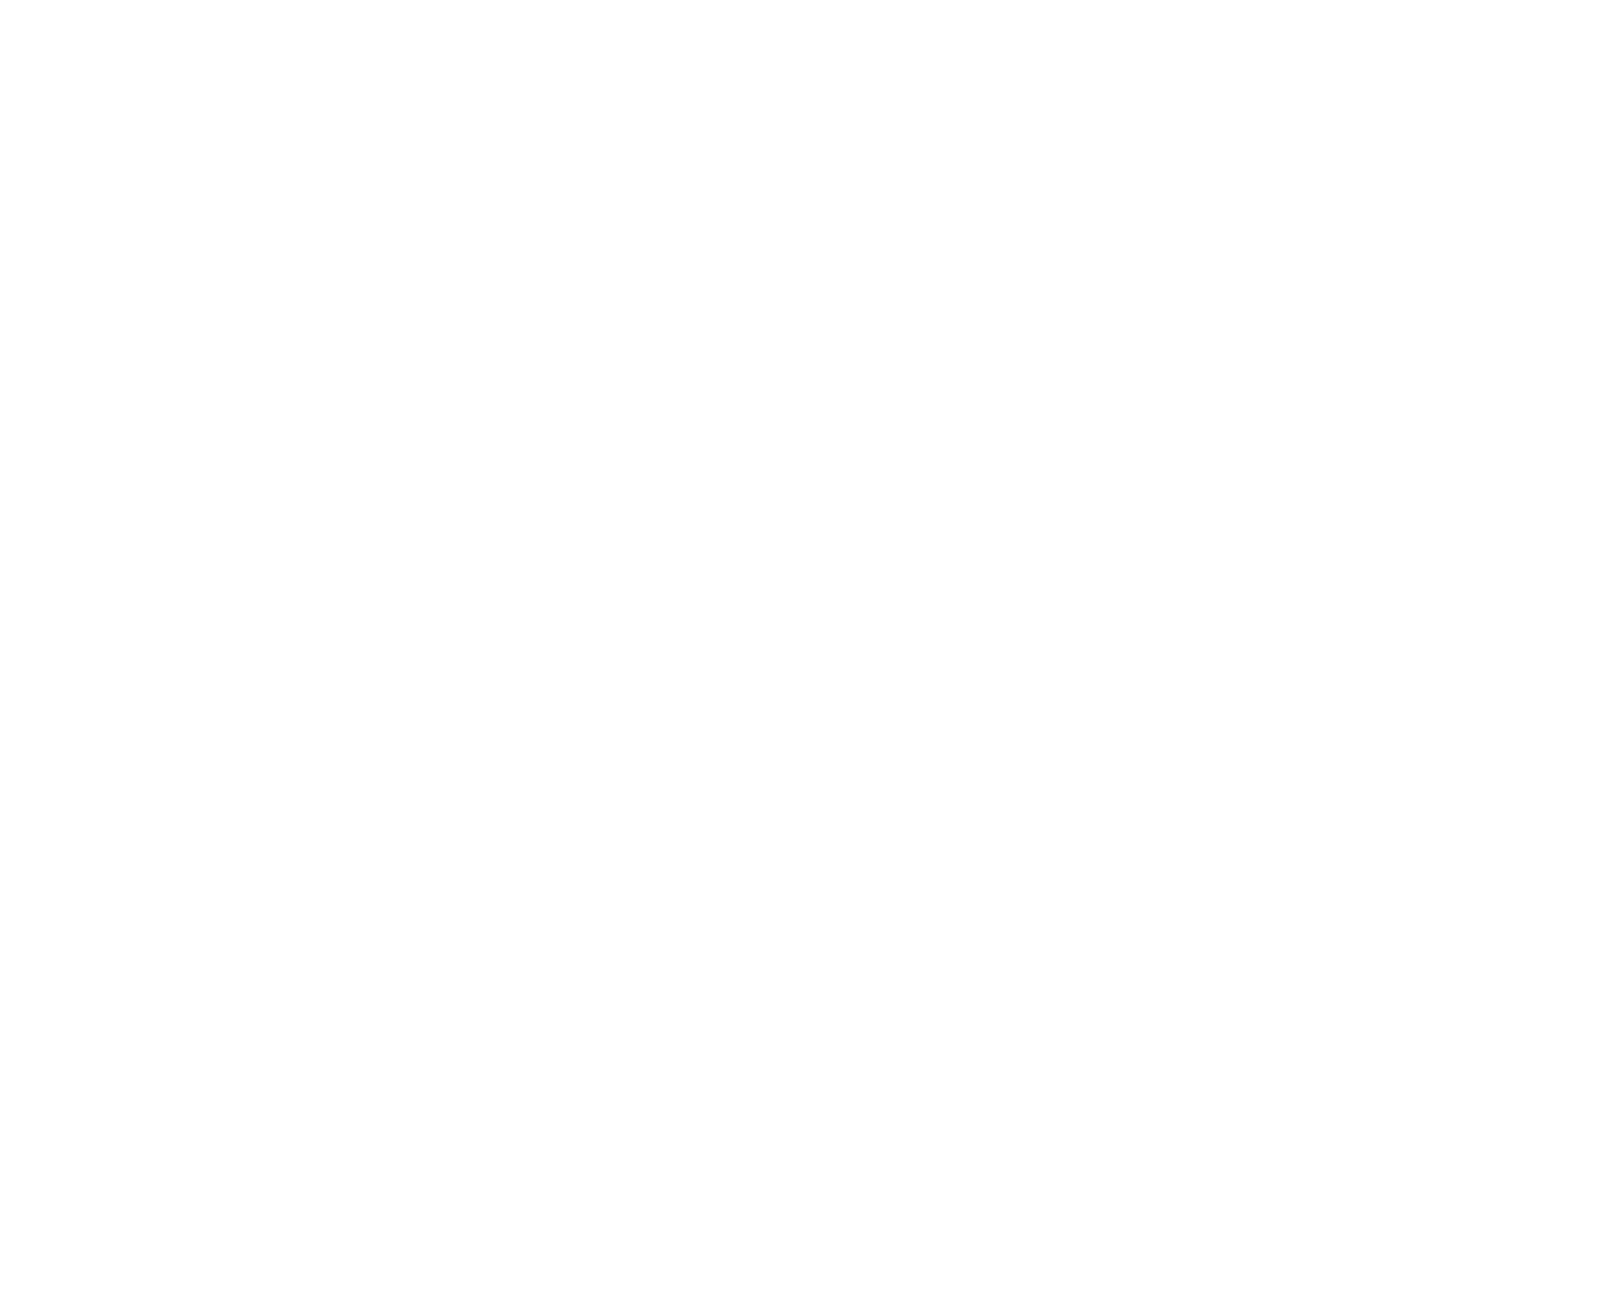

In [7]:
set_theme!(
    fontsize=25,
    Legend=(labelsize=20,),
    Axis=(
        xgridvisible=false,
        ygridvisible=false,
    ),
)

fig = Figure(size=(800, 650))

In [8]:
num_nodes_list = 600:200:6000
xor_delay_list = 1:25
input_std_0_scaled_av = zeros(length(num_nodes_list), length(xor_delay_list))
input_std_0_scaled_std = zeros(length(num_nodes_list), length(xor_delay_list))
max_slope_av = zeros(length(num_nodes_list), length(xor_delay_list))
max_slope_std = zeros(length(num_nodes_list), length(xor_delay_list))

for (i, num_nodes) in enumerate(num_nodes_list)
    for (j, xor_delay) in enumerate(xor_delay_list)
        input_std_0_scaled_av[i, j], input_std_0_scaled_std[i, j], max_slope_av[i, j], max_slope_std[i, j] = calc_max_slope(num_nodes, xor_delay, input_std_grid_scaled)
    end
end

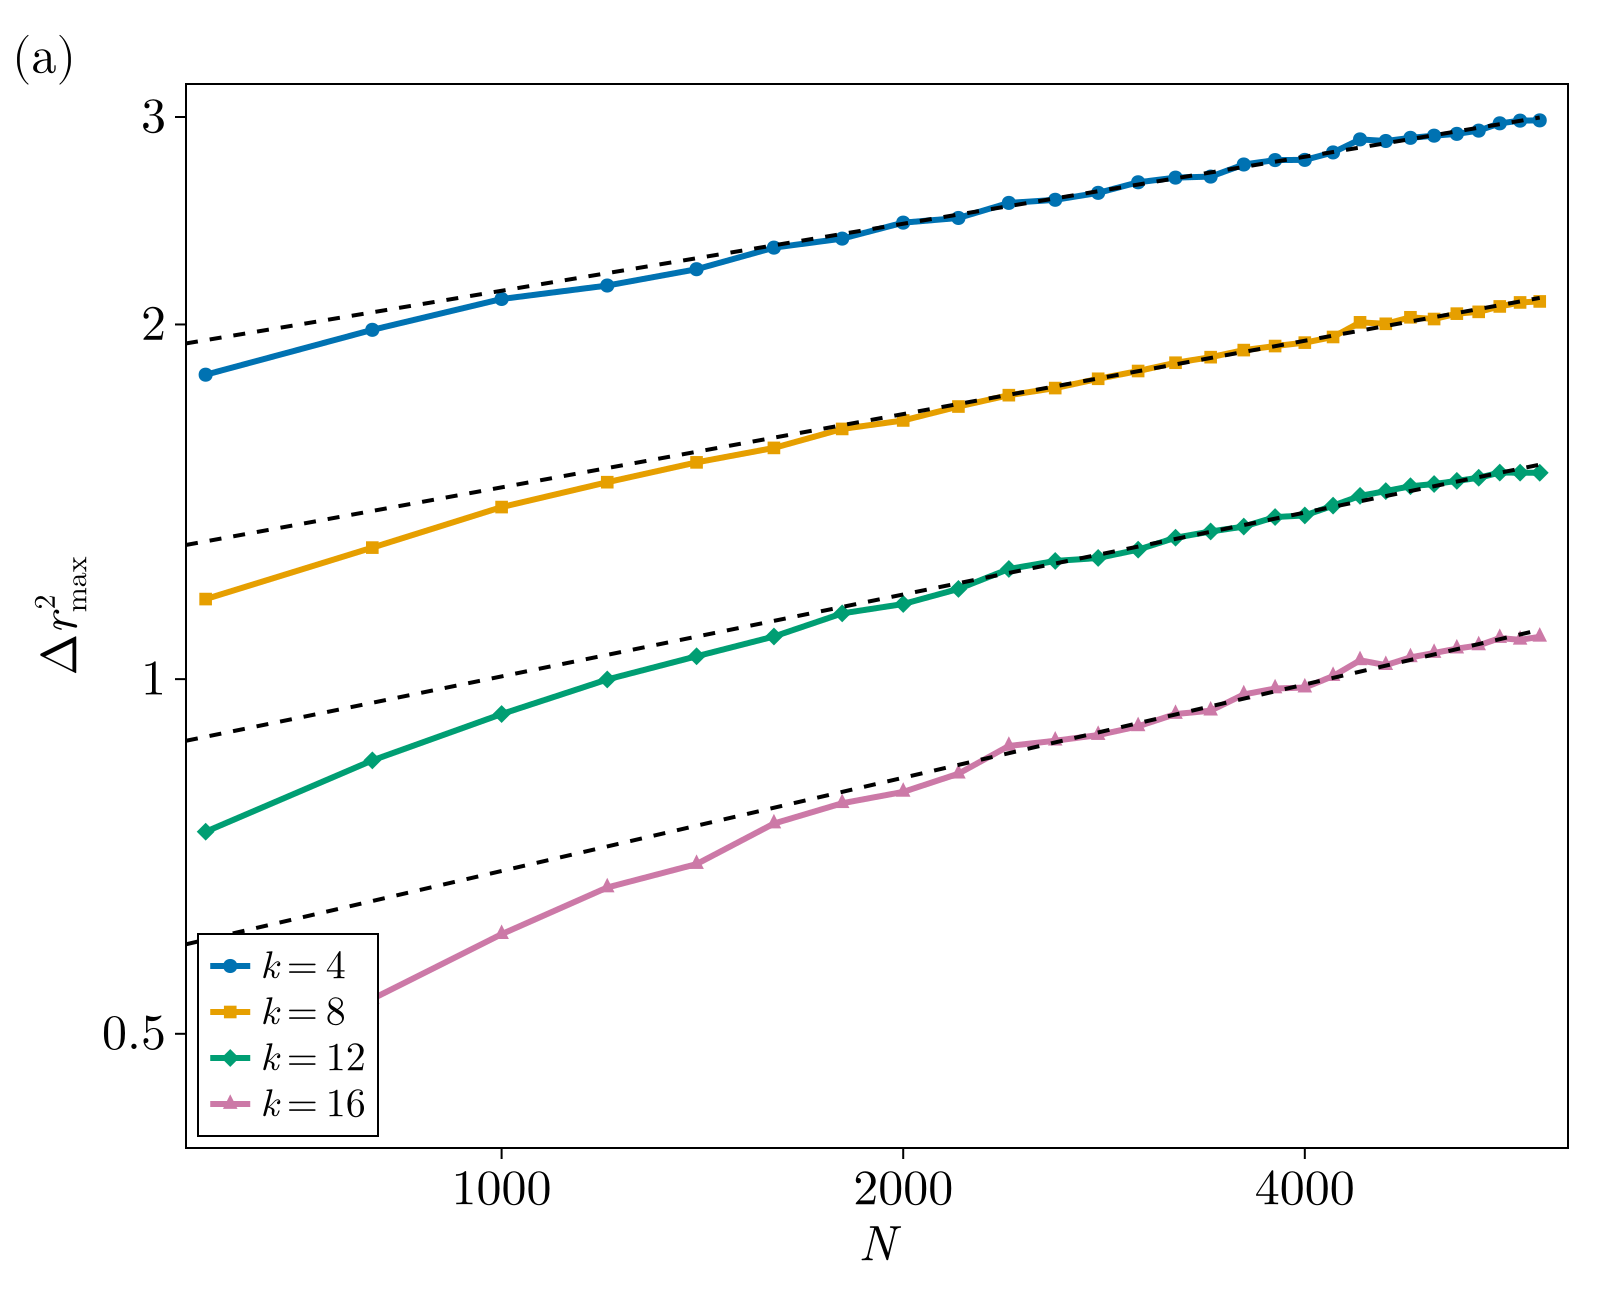

In [9]:
# Fitting for N > 2200
slope_4, _, intercept_4, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 4]), log(2200), maximum(log.(num_nodes_list)))
slope_8, _, intercept_8, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 8]), log(2200), maximum(log.(num_nodes_list)))
slope_12, _, intercept_12, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 12]), log(2200), maximum(log.(num_nodes_list)))
slope_16, _, intercept_16, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 16]), log(2200), maximum(log.(num_nodes_list)))

xs = 500:6000
ys_4 = exp(intercept_4) * xs .^ slope_4
ys_8 = exp(intercept_8) * xs .^ slope_8
ys_12 = exp(intercept_12) * xs .^ slope_12
ys_16 = exp(intercept_16) * xs .^ slope_16

ax = Axis(fig[1, 1];
    xlabel=L"N",
    ylabel=L"\Delta r^2_{\mathrm{max}}",
    xscale=log10,
    yscale=log10,
    xticks=([1000, 2000, 4000], [L"1000", L"2000", L"4000"]),
    yticks=([0.5, 1, 2, 3], [L"0.5", L"1", L"2", L"3"]))

xlims!(ax, 580, 6300)
ylims!(ax, 0.4, 3.2)

scatterlines!(ax, num_nodes_list, max_slope_av[:, 4], markersize = 10, 
    linewidth=3, label=L"k = 4", marker=:circle)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 8], markersize = 10, 
    linewidth=3, label=L"k = 8", marker=:rect)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 12], markersize = 10, 
    linewidth=3, label=L"k = 12", marker=:diamond)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 16], markersize = 10, 
    linewidth=3, label=L"k = 16", marker=:utriangle)

lines!(ax, xs, ys_4, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_8, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_12, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_16, color=:black, linestyle=:dash, linewidth=2)

axislegend(ax; position=:lb)

Label(fig[1, 1, TopLeft()], L"\mathrm{(a)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

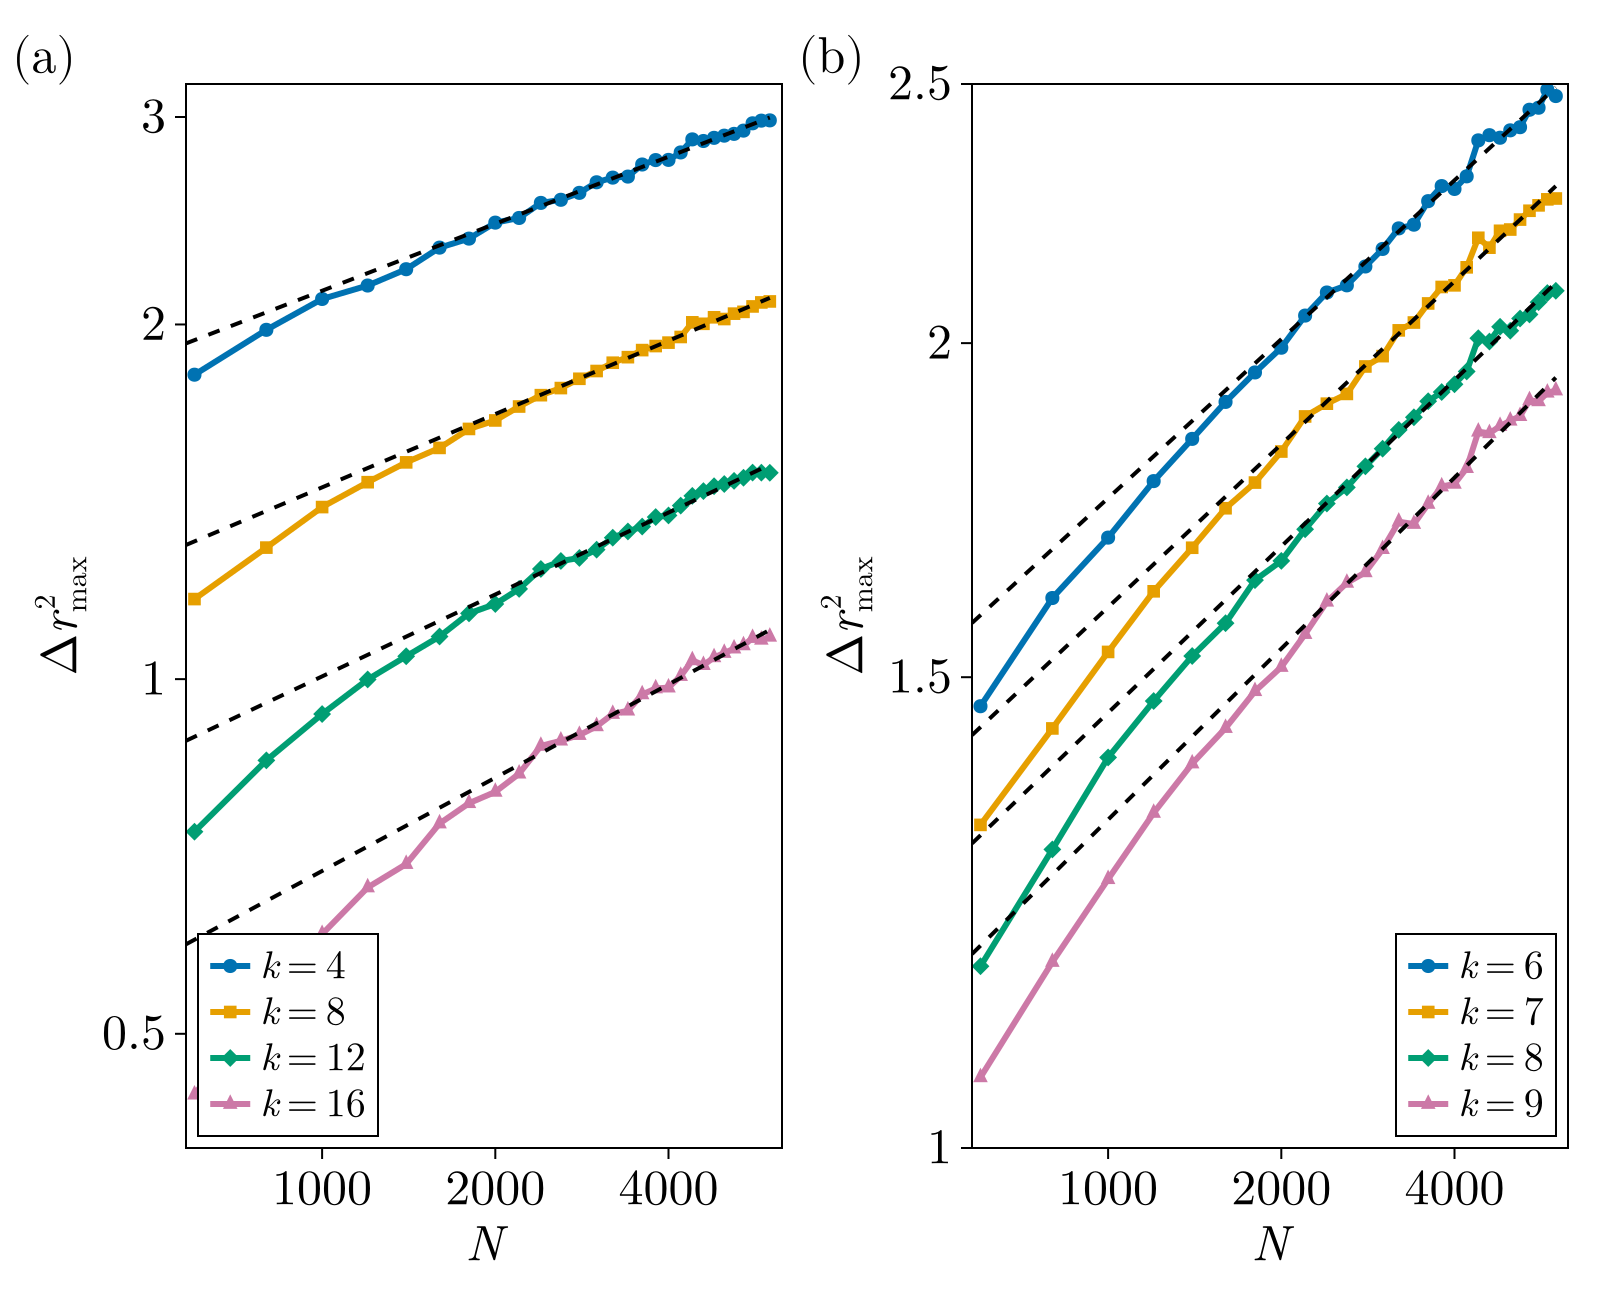

In [10]:
# Fitting for N > 2200
slope_6, _, intercept_6, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 6]), log(2200), maximum(log.(num_nodes_list)))
slope_7, _, intercept_7, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 7]), log(2200), maximum(log.(num_nodes_list)))
slope_9, _, intercept_9, _ = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, 9]), log(2200), maximum(log.(num_nodes_list)))

ys_6 = exp(intercept_6) * xs .^ slope_6
ys_7 = exp(intercept_7) * xs .^ slope_7
ys_9 = exp(intercept_9) * xs .^ slope_9

ax = Axis(fig[1, 2];
    xlabel=L"N",
    ylabel=L"\Delta r^2_{\mathrm{max}}",
    xscale=log10,
    yscale=log10,
    xticks=([1000, 2000, 4000], [L"1000", L"2000", L"4000"]),
    yticks=(1.0:0.5:2.5, [L"1", L"1.5", L"2", L"2.5"]))

scatterlines!(ax, num_nodes_list, max_slope_av[:, 6], markersize = 10, 
    linewidth=3, label=L"k = 6", marker=:circle)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 7], markersize = 10, 
    linewidth=3, label=L"k = 7", marker=:rect)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 8], markersize = 10, 
    linewidth=3, label=L"k = 8", marker=:diamond)
scatterlines!(ax, num_nodes_list, max_slope_av[:, 9], markersize = 10, 
    linewidth=3, label=L"k = 9", marker=:utriangle)

lines!(ax, xs, ys_6, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_7, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_8, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_9, color=:black, linestyle=:dash, linewidth=2)

xlims!(ax, 580, 6300)
ylims!(ax, 1.0, 2.5)

axislegend(ax; position=:rb)

Label(fig[1, 2, TopLeft()], L"\mathrm{(b)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

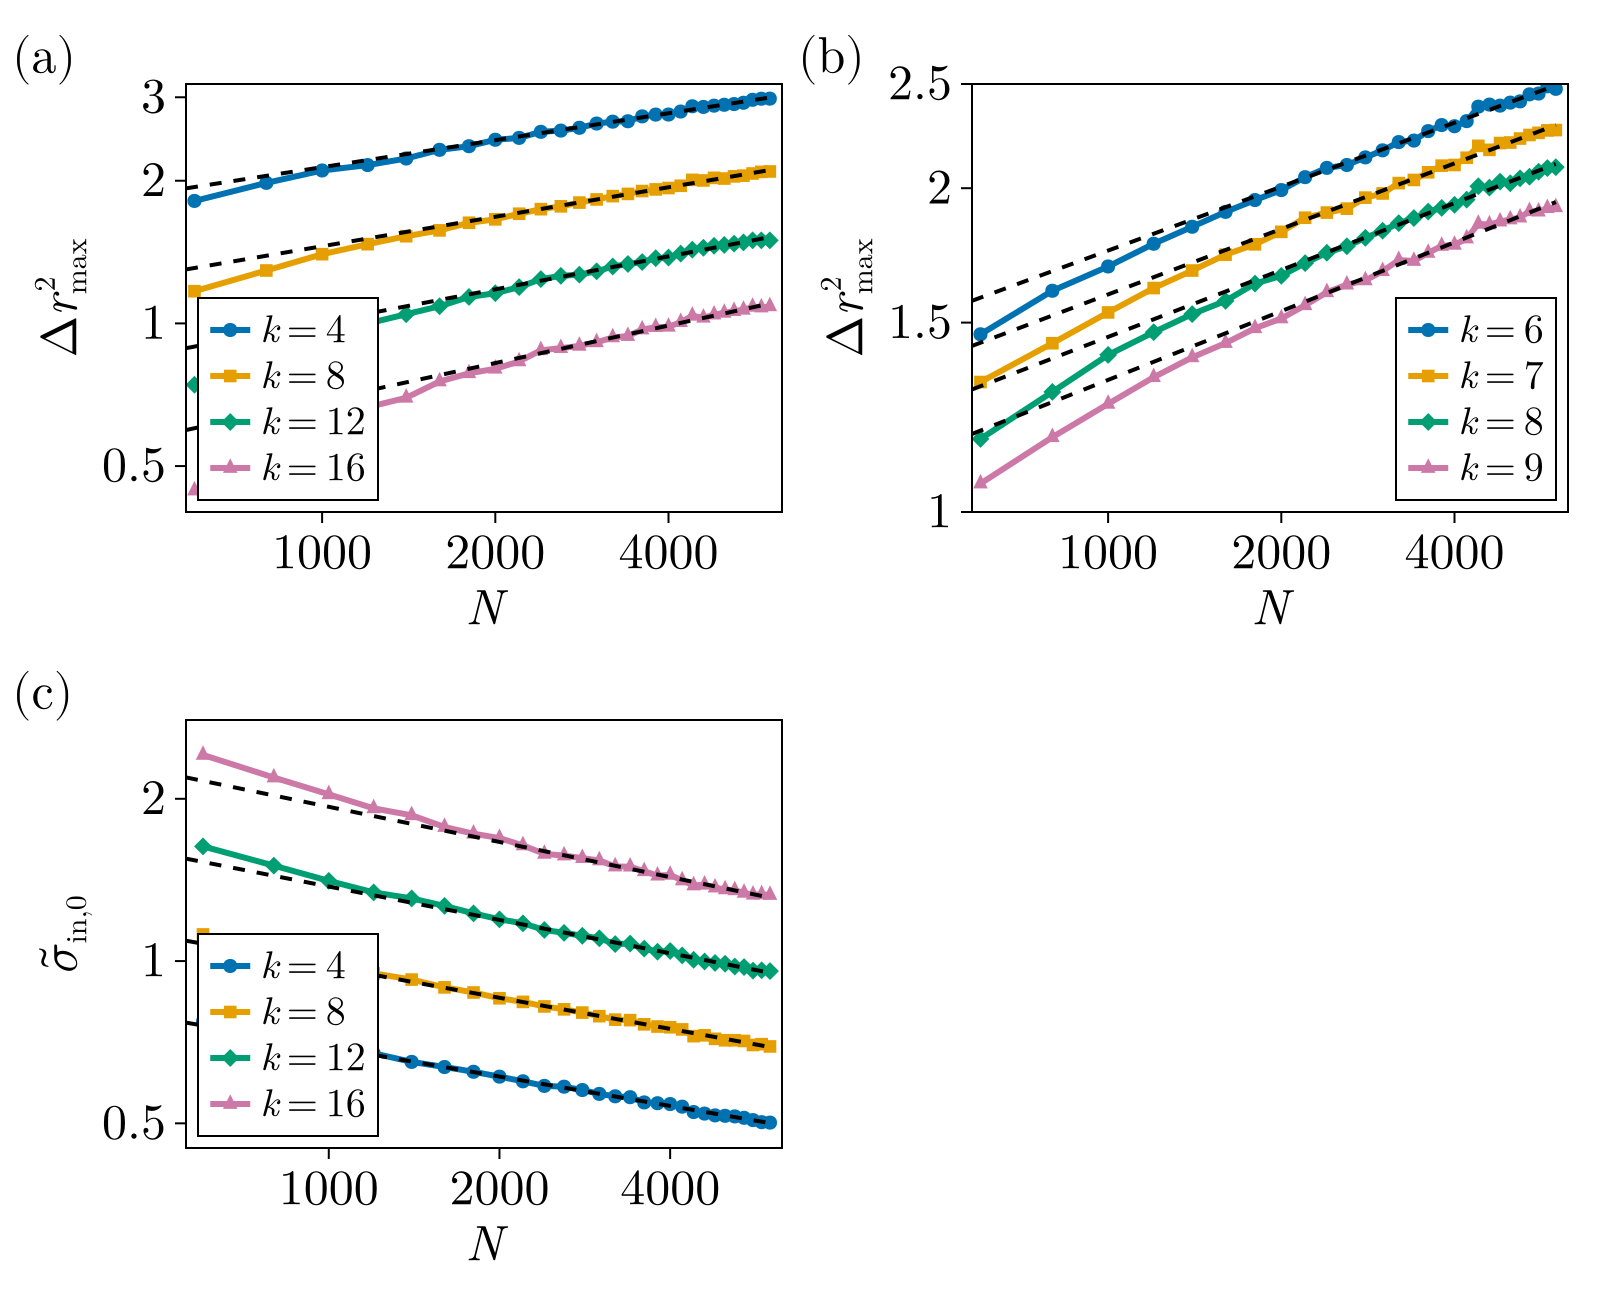

In [11]:
# Fitting for N > 2200
slope_4, _, intercept_4, _ = fit_linear(log.(num_nodes_list), log.(input_std_0_scaled_av[:, 4]), log(2200), maximum(log.(num_nodes_list)))
slope_8, _, intercept_8, _ = fit_linear(log.(num_nodes_list), log.(input_std_0_scaled_av[:, 8]), log(2200), maximum(log.(num_nodes_list)))
slope_12, _, intercept_12, _ = fit_linear(log.(num_nodes_list), log.(input_std_0_scaled_av[:, 12]), log(2200), maximum(log.(num_nodes_list)))
slope_16, _, intercept_16, _ = fit_linear(log.(num_nodes_list), log.(input_std_0_scaled_av[:, 16]), log(2200), maximum(log.(num_nodes_list)))

xs = 500:6000
ys_4 = exp(intercept_4) * xs .^ slope_4
ys_8 = exp(intercept_8) * xs .^ slope_8
ys_12 = exp(intercept_12) * xs .^ slope_12
ys_16 = exp(intercept_16) * xs .^ slope_16

ax = Axis(fig[2, 1];
    xlabel=L"N",
    ylabel=L"\tilde{\sigma}_{\mathrm{in},0}",
    xscale=log10,
    yscale=log10,
    xticks=([1000, 2000, 4000], [L"1000", L"2000", L"4000"]),
    yticks=([0.5, 1, 2, 3], [L"0.5", L"1", L"2", L"3"]))

xlims!(ax, 560, 6300)
ylims!(ax, 0.45, 2.8)

scatterlines!(ax, num_nodes_list, input_std_0_scaled_av[:, 4], markersize = 10, 
    linewidth=3, label=L"k = 4", marker=:circle)
scatterlines!(ax, num_nodes_list, input_std_0_scaled_av[:, 8], markersize = 10, 
    linewidth=3, label=L"k = 8", marker=:rect)
scatterlines!(ax, num_nodes_list, input_std_0_scaled_av[:, 12], markersize = 10, 
    linewidth=3, label=L"k = 12", marker=:diamond)
scatterlines!(ax, num_nodes_list, input_std_0_scaled_av[:, 16], markersize = 10, 
    linewidth=3, label=L"k = 16", marker=:utriangle)

lines!(ax, xs, ys_4, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_8, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_12, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_16, color=:black, linestyle=:dash, linewidth=2)

axislegend(ax; position=:lb)

Label(fig[2, 1, TopLeft()], L"\mathrm{(c)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

In [12]:
# Fitting for N > 2200
exp_delta_r2_max = Float64[]
exp_delta_r2_max_error = Float64[]
for i in 1:25
    slope, slope_error, intercept, intercept_error = fit_linear(log.(num_nodes_list), log.(max_slope_av[:, i]), log(2200), maximum(log.(num_nodes_list)))
    push!(exp_delta_r2_max, slope)
    push!(exp_delta_r2_max_error, slope_error)
end

In [13]:
# Fitting for N > 2200
exp_sigma_in_0 = Float64[]
exp_sigma_in_0_error = Float64[]
for i in 1:25
    slope, slope_error, intercept, intercept_error = fit_linear(log.(num_nodes_list), log.(input_std_0_scaled_av[:, i]), log(2200), maximum(log.(num_nodes_list)))
    push!(exp_sigma_in_0, slope)
    push!(exp_sigma_in_0_error, slope_error)
end

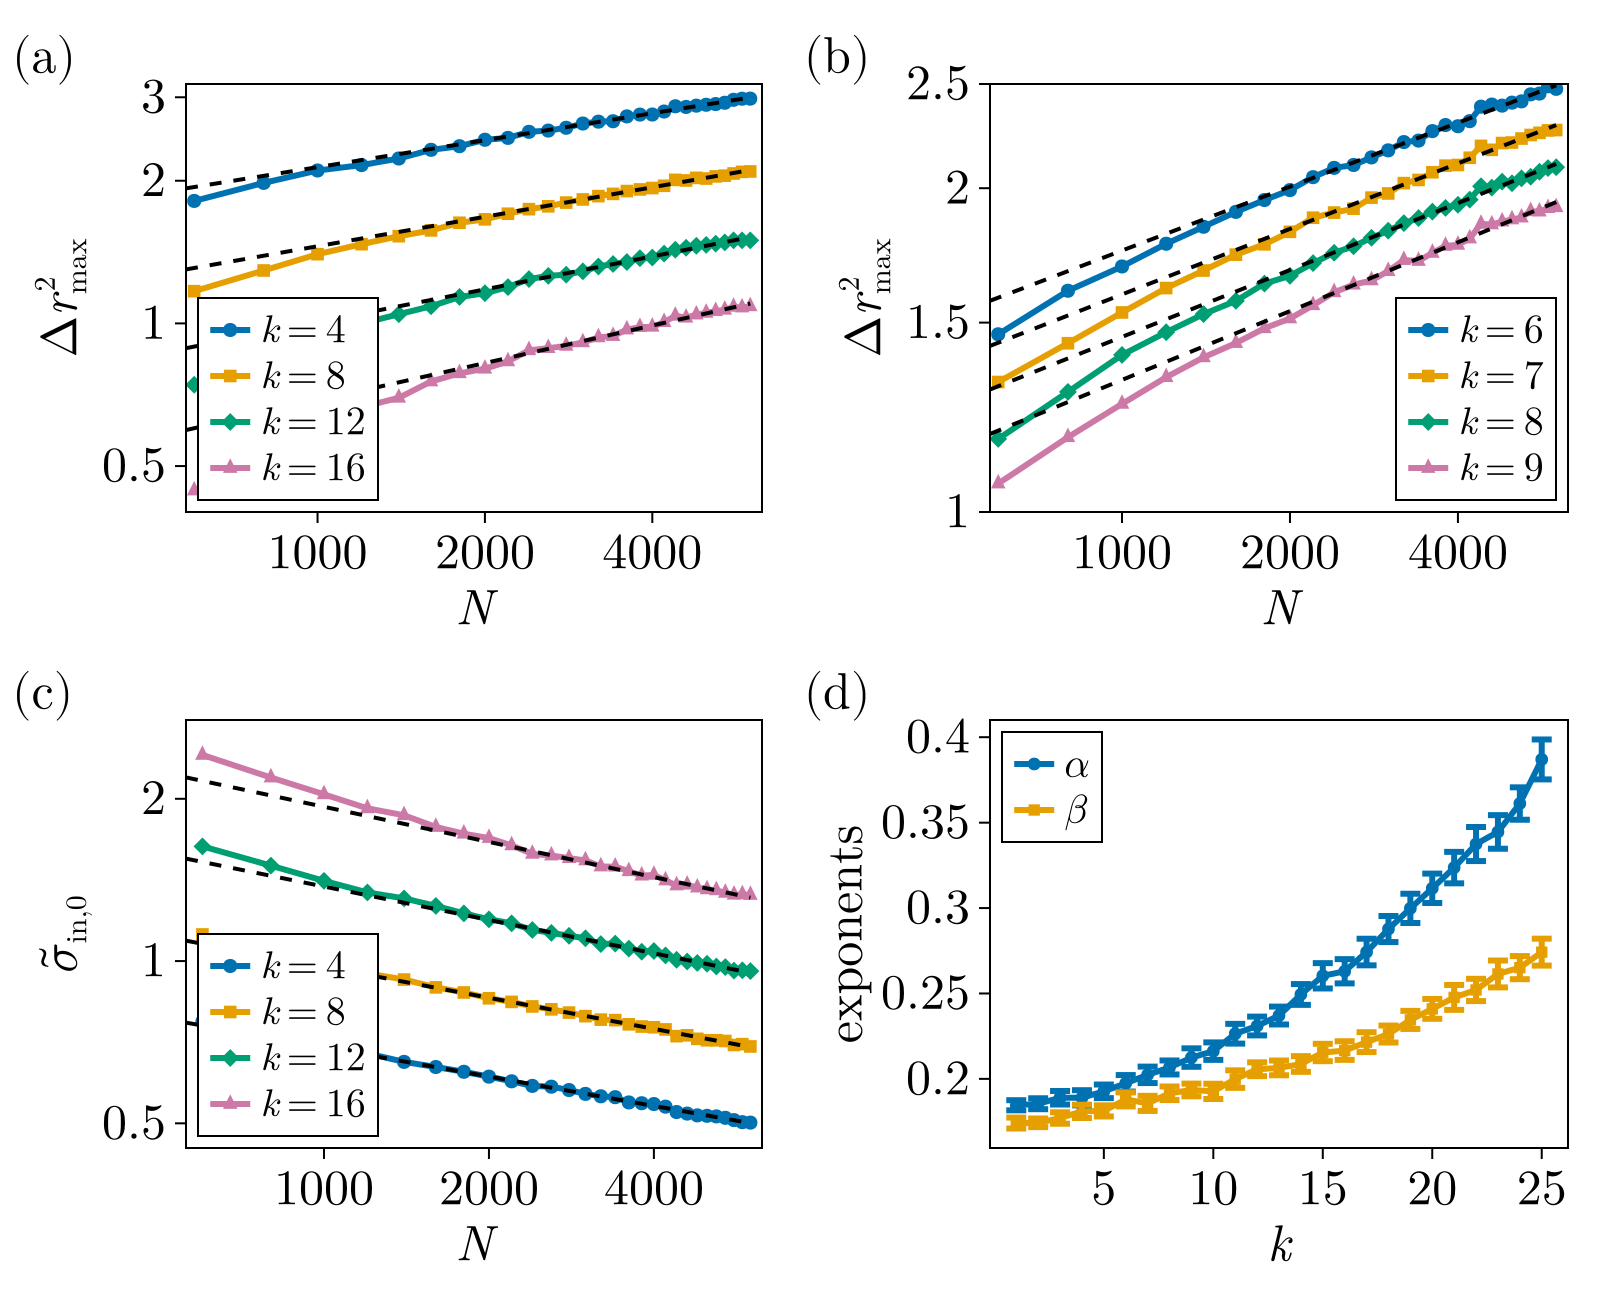

In [14]:
ax = Axis(fig[2, 2];
    xlabel=L"k",
    ylabel=L"\mathrm{exponents}",
    xticks=(5:5:25, [L"5", L"10", L"15", L"20", L"25"]),
    yticks=(0.15:0.05:0.45, [L"0.15", L"0.2", L"0.25", L"0.3", L"0.35", L"0.4", L"0.45"]))

scatterlines!(ax, 1:25, exp_delta_r2_max, label=L"\alpha", linewidth=3, marker=:circle)
scatterlines!(ax, 1:25, -exp_sigma_in_0, label=L"\beta", linewidth=3, marker=:rect)

errorbars!(ax, 1:25, exp_delta_r2_max, exp_delta_r2_max_error; linewidth=3, whiskerwidth = 10)
errorbars!(ax, 1:25, -exp_sigma_in_0, exp_sigma_in_0_error; linewidth=3, whiskerwidth = 10)

axislegend(ax; position=:lt)

Label(fig[2, 2, TopLeft()], L"\mathrm{(d)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

colgap!(fig.layout, 1, Relative(0.05))

fig

In [15]:
save("fig4_finite_size_scaling.pdf", fig)

CairoMakie.Screen{PDF}
